# exp004: OR-toolsによるVRPソルバー実装（tai385）

Google OR-toolsを使用してtai385インスタンス（386ノード、46車両）のVRPを解く
距離計算でDecimal.quantize(ROUND_HALF_UP)を使用し、TSPLIBの標準に準拠

In [1]:
import sys
import os
import yaml
import time
import numpy as np
import matplotlib.pyplot as plt
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

from utils import VRPDataReader, read_solution

## 1. 設定ファイルの読み込み

In [2]:
with open('config.yaml', 'r') as f:
    config = yaml.safe_load(f)

print("設定内容:")
print(yaml.dump(config, default_flow_style=False))

設定内容:
experiment:
  description: "OR-toolsVRP\u30BD\u30EB\u30D0\u30FC\uFF08Decimal.quantize()\u7248\u3001\
    TAI385\u30A4\u30F3\u30B9\u30BF\u30F3\u30B9\u3001600\u79D2\uFF09"
  experiment_id: exp004
paths:
  output_dir: ../../results/exp004
  sol_file: ../../data/tai385.sol
  vrp_file: ../../data/tai385.vrp
solver:
  first_solution_strategy: PATH_CHEAPEST_ARC
  local_search_metaheuristic: GUIDED_LOCAL_SEARCH
  solution_limit: 100
  time_limit_seconds: 600



## 2. VRPデータの読み込み

In [3]:
vrp_reader = VRPDataReader(config['paths']['vrp_file'])
vrp_data = vrp_reader.parse()

print(f"インスタンス名: {vrp_data['name']}")
print(f"ノード数: {vrp_data['dimension']}")
print(f"車両数: {vrp_data['num_vehicles']}")
print(f"車両容量: {vrp_data['capacity']}")
print(f"最適値: {vrp_data['optimal_value']}")

インスタンス名: Tai385
ノード数: 386
車両数: 46
車両容量: 65
最適値: 24431.44


In [4]:
distance_matrix = vrp_reader.compute_distance_matrix()
print(f"距離行列のサイズ: {distance_matrix.shape}")
print(f"最大距離: {np.max(distance_matrix)}")
print(f"最小距離（非ゼロ）: {np.min(distance_matrix[distance_matrix > 0])}")

距離行列のサイズ: (386, 386)
最大距離: 996.0
最小距離（非ゼロ）: 5.0


In [5]:
optimal_routes, optimal_cost = read_solution(config['paths']['sol_file'])
print(f"最適解のコスト: {optimal_cost}")
print(f"最適解のルート数: {len(optimal_routes)}")
for i, route in enumerate(optimal_routes, 1):
    print(f"  ルート{i}: {len(route)}ノード")

最適解のコスト: 24366.41339
最適解のルート数: 47
  ルート1: 6ノード
  ルート2: 16ノード
  ルート3: 7ノード
  ルート4: 5ノード
  ルート5: 4ノード
  ルート6: 2ノード
  ルート7: 12ノード
  ルート8: 4ノード
  ルート9: 7ノード
  ルート10: 4ノード
  ルート11: 3ノード
  ルート12: 3ノード
  ルート13: 8ノード
  ルート14: 4ノード
  ルート15: 3ノード
  ルート16: 3ノード
  ルート17: 3ノード
  ルート18: 4ノード
  ルート19: 4ノード
  ルート20: 8ノード
  ルート21: 2ノード
  ルート22: 2ノード
  ルート23: 15ノード
  ルート24: 1ノード
  ルート25: 11ノード
  ルート26: 23ノード
  ルート27: 15ノード
  ルート28: 2ノード
  ルート29: 19ノード
  ルート30: 26ノード
  ルート31: 7ノード
  ルート32: 4ノード
  ルート33: 1ノード
  ルート34: 2ノード
  ルート35: 18ノード
  ルート36: 9ノード
  ルート37: 30ノード
  ルート38: 10ノード
  ルート39: 8ノード
  ルート40: 13ノード
  ルート41: 5ノード
  ルート42: 1ノード
  ルート43: 14ノード
  ルート44: 2ノード
  ルート45: 6ノード
  ルート46: 16ノード
  ルート47: 13ノード


## 3. OR-toolsのデータモデル作成

In [6]:
def create_data_model():
    data = {}
    data['distance_matrix'] = distance_matrix.astype(int).tolist()
    data['demands'] = [vrp_data['demands'].get(i, 0) for i in range(1, vrp_data['dimension'] + 1)]
    data['vehicle_capacities'] = [vrp_data['capacity']] * vrp_data['num_vehicles']
    data['num_vehicles'] = vrp_data['num_vehicles']
    data['depot'] = 0
    return data

data = create_data_model()
print(f"データモデル作成完了")
print(f"需要量の合計: {sum(data['demands'])}")
print(f"総容量: {sum(data['vehicle_capacities'])}")

データモデル作成完了
需要量の合計: 2983
総容量: 2990


## 4. VRPソルバーの実装

In [7]:
def print_solution(data, manager, routing, solution):
    total_distance = 0
    total_load = 0
    routes = []
    
    for vehicle_id in range(data['num_vehicles']):
        index = routing.Start(vehicle_id)
        route = []
        route_distance = 0
        route_load = 0
        
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route.append(node_index + 1)  # 1-indexed
            route_load += data['demands'][node_index]
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id)
        
        if len(route) > 1:  # デポのみのルートは除外
            routes.append(route[1:])  # デポを除外
            print(f"ルート {vehicle_id + 1}: {route[1:]}")
            print(f"  距離: {route_distance}, 積載量: {route_load}")
            total_distance += route_distance
            total_load += route_load
    
    print(f"\n総距離: {total_distance}")
    print(f"総積載量: {total_load}")
    
    return routes, total_distance

In [8]:
def solve_vrp():
    manager = pywrapcp.RoutingIndexManager(
        len(data['distance_matrix']),
        data['num_vehicles'],
        data['depot']
    )
    
    routing = pywrapcp.RoutingModel(manager)
    
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data['distance_matrix'][from_node][to_node]
    
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data['demands'][from_node]
    
    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],
        True,  # start cumul to zero
        'Capacity'
    )
    
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    )
    search_parameters.time_limit.seconds = config['solver']['time_limit_seconds']
    
    print("ソルバー実行中...")
    start_time = time.time()
    solution = routing.SolveWithParameters(search_parameters)
    solve_time = time.time() - start_time
    
    if solution:
        print(f"\n解が見つかりました（計算時間: {solve_time:.2f}秒）")
        routes, total_distance = print_solution(data, manager, routing, solution)
        return routes, total_distance, solve_time
    else:
        print("解が見つかりませんでした")
        return None, None, solve_time

In [9]:
routes, total_distance, solve_time = solve_vrp()

ソルバー実行中...



解が見つかりました（計算時間: 600.00秒）
ルート 1: [340, 339, 333, 342, 343, 344, 203, 345, 190, 186]
  距離: 652, 積載量: 65
ルート 2: [364, 359, 383]
  距離: 990, 積載量: 65
ルート 3: [338, 336, 376, 384, 360]
  距離: 1009, 積載量: 65
ルート 4: [3, 200, 205, 207, 210, 185, 270]
  距離: 649, 積載量: 65
ルート 5: [127, 123, 111, 67, 16, 17, 18, 20, 61, 62, 74, 104]
  距離: 772, 積載量: 65
ルート 6: [365, 362, 363, 324, 325, 330]
  距離: 791, 積載量: 65
ルート 7: [180, 368, 209, 341, 332, 337]
  距離: 663, 積載量: 65
ルート 8: [102, 189, 83, 57, 56, 188, 52, 283, 281, 259, 282, 54, 55, 86, 284, 320]
  距離: 635, 積載量: 65
ルート 9: [289, 288, 277, 263, 276]
  距離: 254, 積載量: 65
ルート 10: [254, 227, 226, 351, 356, 357, 355, 354]
  距離: 845, 積載量: 65
ルート 11: [361, 358, 326]
  距離: 941, 積載量: 65
ルート 12: [377, 103, 125, 107, 76, 77, 60, 59, 79, 80, 81]
  距離: 587, 積載量: 65
ルート 13: [271, 334, 268, 298]
  距離: 431, 積載量: 65
ルート 14: [372, 26, 31, 13, 32, 36, 42, 47, 48, 49, 45, 43, 44, 385, 46, 41, 39, 37, 35, 33, 220, 218, 208, 196, 192, 172]
  距離: 1503, 積載量: 65
ルート 15: [228, 229, 25

## 5. 結果の可視化

In [10]:
def plot_routes(routes, vrp_data, title="VRP Solution"):
    plt.figure(figsize=(12, 8))
    
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']
    
    depot_x, depot_y = vrp_data['node_coords'][1]
    plt.scatter(depot_x, depot_y, c='black', s=200, marker='s', label='Depot', zorder=5)
    
    for i, route in enumerate(routes):
        color = colors[i % len(colors)]
        
        prev_x, prev_y = depot_x, depot_y
        
        for node in route:
            x, y = vrp_data['node_coords'][node]
            plt.scatter(x, y, c=color, s=100, zorder=4)
            plt.arrow(prev_x, prev_y, x - prev_x, y - prev_y,
                     head_width=1, head_length=0.5, fc=color, ec=color, alpha=0.6)
            plt.text(x, y, str(node), fontsize=8, ha='center', va='bottom')
            prev_x, prev_y = x, y
        
        plt.arrow(prev_x, prev_y, depot_x - prev_x, depot_y - prev_y,
                 head_width=1, head_length=0.5, fc=color, ec=color, alpha=0.6,
                 label=f'Route {i+1}')
    
    plt.xlabel('X座標')
    plt.ylabel('Y座標')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

/var/folders/pl/pr1pq3056r12g5vx0j398yxr0000gp/T/ipykernel_22332/2092790511.py:31: UserWarning: Glyph 24231 (\N{CJK UNIFIED IDEOGRAPH-5EA7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/pl/pr1pq3056r12g5vx0j398yxr0000gp/T/ipykernel_22332/2092790511.py:31: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


/Users/koki.ogai/Documents/ghq/github.com/oddgai/datascience-playground/vrp-with-claude-code/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 24231 (\N{CJK UNIFIED IDEOGRAPH-5EA7}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/koki.ogai/Documents/ghq/github.com/oddgai/datascience-playground/vrp-with-claude-code/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


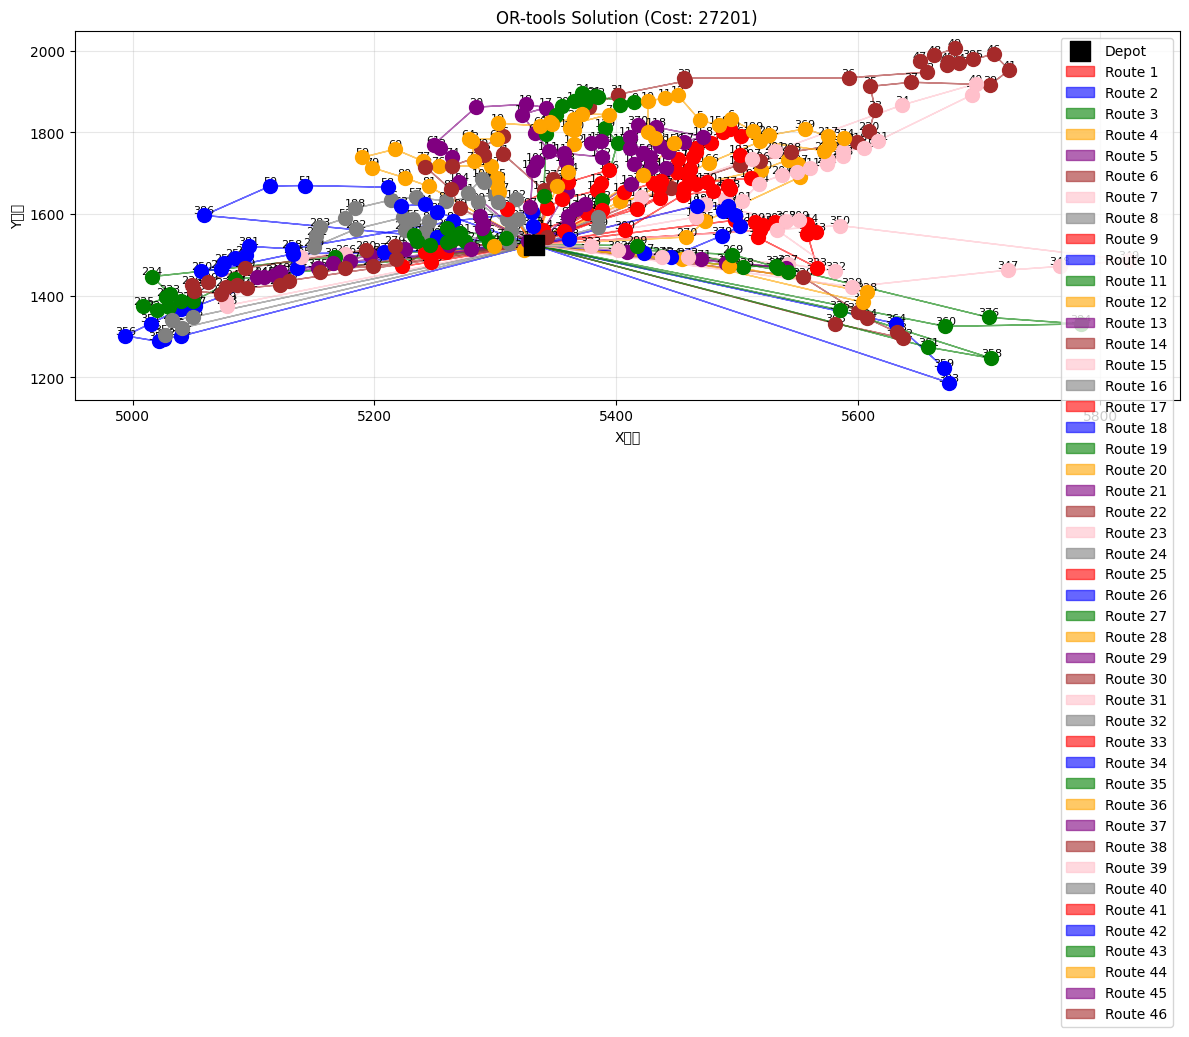

In [11]:
if routes:
    plot_routes(routes, vrp_data, f"OR-tools Solution (Cost: {total_distance})")

def plot_comparison(our_routes, optimal_routes, vrp_data, our_cost, optimal_cost, exp_id):
    """上下に並べて解の比較を可視化"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))
    
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'olive', 'navy', 'teal', 'maroon', 'indigo']
    
    depot_x, depot_y = vrp_data['node_coords'][1]
    
    # 上側：得られた解
    ax1.scatter(depot_x, depot_y, c='black', s=200, marker='s', label='Depot', zorder=5)
    for i, route in enumerate(our_routes):
        color = colors[i % len(colors)]
        prev_x, prev_y = depot_x, depot_y
        
        for node in route:
            x, y = vrp_data['node_coords'][node]
            ax1.scatter(x, y, c=color, s=60, zorder=4)
            ax1.arrow(prev_x, prev_y, x - prev_x, y - prev_y,
                     head_width=1, head_length=0.5, fc=color, ec=color, alpha=0.6)
            prev_x, prev_y = x, y
        
        ax1.arrow(prev_x, prev_y, depot_x - prev_x, depot_y - prev_y,
                 head_width=1, head_length=0.5, fc=color, ec=color, alpha=0.6)
    
    ax1.set_title(f'OR-tools解 (コスト: {our_cost}, ギャップ: {((our_cost - optimal_cost) / optimal_cost * 100):.2f}%)', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # 下側：最適解
    ax2.scatter(depot_x, depot_y, c='black', s=200, marker='s', label='Depot', zorder=5)
    for i, route in enumerate(optimal_routes):
        color = colors[i % len(colors)]
        prev_x, prev_y = depot_x, depot_y
        
        for node in route:
            x, y = vrp_data['node_coords'][node]
            ax2.scatter(x, y, c=color, s=60, zorder=4)
            ax2.arrow(prev_x, prev_y, x - prev_x, y - prev_y,
                     head_width=1, head_length=0.5, fc=color, ec=color, alpha=0.6)
            prev_x, prev_y = x, y
        
        ax2.arrow(prev_x, prev_y, depot_x - prev_x, depot_y - prev_y,
                 head_width=1, head_length=0.5, fc=color, ec=color, alpha=0.6)
    
    ax2.set_title(f'最適解 (コスト: {optimal_cost})', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Artifactsディレクトリに保存
    artifacts_dir = f"../../artifacts/{exp_id}"
    os.makedirs(artifacts_dir, exist_ok=True)
    comparison_path = os.path.join(artifacts_dir, f"{vrp_data['name']}_comparison_{exp_id}.png")
    plt.savefig(comparison_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"比較図を保存しました: {comparison_path}")
    
    plt.show()

if routes:
    plot_comparison(routes, optimal_routes, vrp_data, total_distance, optimal_cost, config['experiment']['experiment_id'])

/var/folders/pl/pr1pq3056r12g5vx0j398yxr0000gp/T/ipykernel_22332/188347598.py:51: UserWarning: Glyph 24231 (\N{CJK UNIFIED IDEOGRAPH-5EA7}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/pl/pr1pq3056r12g5vx0j398yxr0000gp/T/ipykernel_22332/188347598.py:51: UserWarning: Glyph 27161 (\N{CJK UNIFIED IDEOGRAPH-6A19}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/pl/pr1pq3056r12g5vx0j398yxr0000gp/T/ipykernel_22332/188347598.py:51: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/pl/pr1pq3056r12g5vx0j398yxr0000gp/T/ipykernel_22332/188347598.py:51: UserWarning: Glyph 12467 (\N{KATAKANA LETTER KO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/pl/pr1pq3056r12g5vx0j398yxr0000gp/T/ipykernel_22332/188347598.py:51: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/pl/pr1pq3056r12g5vx0j398yxr0

/var/folders/pl/pr1pq3056r12g5vx0j398yxr0000gp/T/ipykernel_22332/188347598.py:57: UserWarning: Glyph 26368 (\N{CJK UNIFIED IDEOGRAPH-6700}) missing from font(s) DejaVu Sans.
  plt.savefig(comparison_path, dpi=150, bbox_inches='tight', facecolor='white')
/var/folders/pl/pr1pq3056r12g5vx0j398yxr0000gp/T/ipykernel_22332/188347598.py:57: UserWarning: Glyph 36969 (\N{CJK UNIFIED IDEOGRAPH-9069}) missing from font(s) DejaVu Sans.
  plt.savefig(comparison_path, dpi=150, bbox_inches='tight', facecolor='white')


比較図を保存しました: ../../artifacts/exp004/Tai385_comparison_exp004.png


/Users/koki.ogai/Documents/ghq/github.com/oddgai/datascience-playground/vrp-with-claude-code/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 35299 (\N{CJK UNIFIED IDEOGRAPH-89E3}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/koki.ogai/Documents/ghq/github.com/oddgai/datascience-playground/vrp-with-claude-code/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12467 (\N{KATAKANA LETTER KO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/koki.ogai/Documents/ghq/github.com/oddgai/datascience-playground/vrp-with-claude-code/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 12473 (\N{KATAKANA LETTER SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/koki.ogai/Documents/ghq/github.com/oddgai/datascience-playground/vrp-with-claude-code/.venv/lib/python3.12/site-packages/IPytho

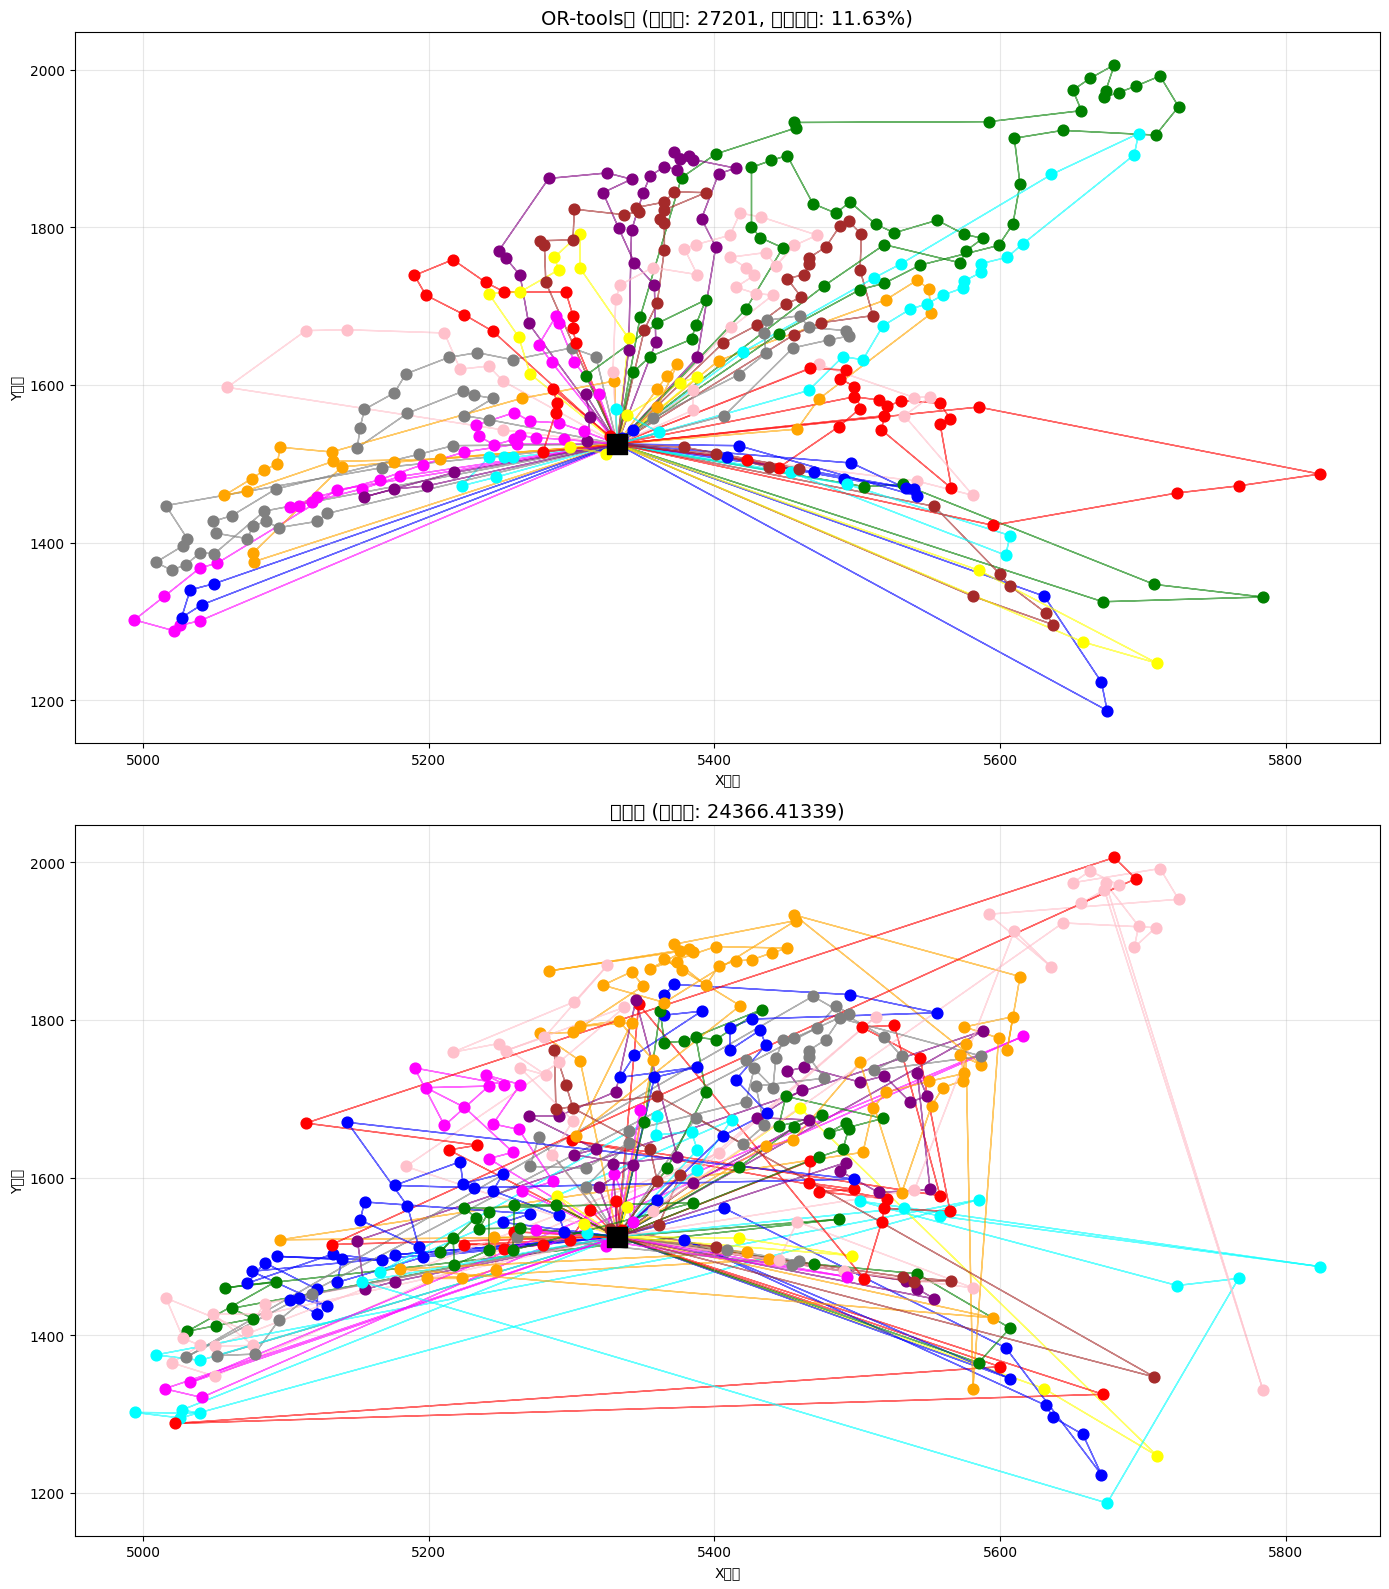

In [12]:
def plot_comparison(our_routes, optimal_routes, vrp_data, our_cost, optimal_cost, exp_id):
    """上下に並べて解の比較を可視化"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 16))
    
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'magenta', 'yellow']
    
    depot_x, depot_y = vrp_data['node_coords'][1]
    
    # 上側：得られた解
    ax1.scatter(depot_x, depot_y, c='black', s=200, marker='s', label='Depot', zorder=5)
    for i, route in enumerate(our_routes):
        color = colors[i % len(colors)]
        prev_x, prev_y = depot_x, depot_y
        
        for node in route:
            x, y = vrp_data['node_coords'][node]
            ax1.scatter(x, y, c=color, s=60, zorder=4)
            ax1.arrow(prev_x, prev_y, x - prev_x, y - prev_y,
                     head_width=1, head_length=0.5, fc=color, ec=color, alpha=0.6)
            prev_x, prev_y = x, y
        
        ax1.arrow(prev_x, prev_y, depot_x - prev_x, depot_y - prev_y,
                 head_width=1, head_length=0.5, fc=color, ec=color, alpha=0.6)
    
    ax1.set_title(f'OR-tools解 (コスト: {our_cost}, ギャップ: {((our_cost - optimal_cost) / optimal_cost * 100):.2f}%)', fontsize=14)
    ax1.set_xlabel('X座標')
    ax1.set_ylabel('Y座標')
    ax1.grid(True, alpha=0.3)
    
    # 下側：最適解
    ax2.scatter(depot_x, depot_y, c='black', s=200, marker='s', label='Depot', zorder=5)
    for i, route in enumerate(optimal_routes):
        color = colors[i % len(colors)]
        prev_x, prev_y = depot_x, depot_y
        
        for node in route:
            x, y = vrp_data['node_coords'][node]
            ax2.scatter(x, y, c=color, s=60, zorder=4)
            ax2.arrow(prev_x, prev_y, x - prev_x, y - prev_y,
                     head_width=1, head_length=0.5, fc=color, ec=color, alpha=0.6)
            prev_x, prev_y = x, y
        
        ax2.arrow(prev_x, prev_y, depot_x - prev_x, depot_y - prev_y,
                 head_width=1, head_length=0.5, fc=color, ec=color, alpha=0.6)
    
    ax2.set_title(f'最適解 (コスト: {optimal_cost})', fontsize=14)
    ax2.set_xlabel('X座標')
    ax2.set_ylabel('Y座標')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Artifactsディレクトリに保存
    artifacts_dir = f"../../artifacts/{exp_id}"
    os.makedirs(artifacts_dir, exist_ok=True)
    comparison_path = os.path.join(artifacts_dir, f"{vrp_data['name']}_comparison_{exp_id}.png")
    plt.savefig(comparison_path, dpi=150, bbox_inches='tight', facecolor='white')
    print(f"比較図を保存しました: {comparison_path}")
    
    plt.show()

if routes:
    plot_comparison(routes, optimal_routes, vrp_data, total_distance, optimal_cost, config['experiment']['experiment_id'])

In [13]:
import json
import os

# ギャップ計算を追加
gap = (total_distance - optimal_cost) / optimal_cost * 100 if routes and total_distance and optimal_cost else None

results = {
    'experiment_id': config['experiment']['experiment_id'],
    'instance': vrp_data['name'],
    'optimal_cost': optimal_cost,
    'solution_cost': total_distance,
    'gap_percentage': gap,
    'solve_time_seconds': solve_time,
    'num_routes': len(routes) if routes else None,
    'solver_settings': config['solver']
}

os.makedirs(config['paths']['output_dir'], exist_ok=True)
results_path = os.path.join(config['paths']['output_dir'], 'exp004_results.json')

with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n結果を保存しました: {results_path}")


結果を保存しました: ../../results/exp004/exp004_results.json


In [14]:
import json
import os

results = {
    'experiment_id': config['experiment']['experiment_id'],
    'instance': vrp_data['name'],
    'optimal_cost': optimal_cost,
    'solution_cost': total_distance,
    'gap_percentage': gap if routes else None,
    'solve_time_seconds': solve_time,
    'num_routes': len(routes) if routes else None,
    'solver_settings': config['solver']
}

os.makedirs(config['paths']['output_dir'], exist_ok=True)
results_path = os.path.join(config['paths']['output_dir'], 'exp002_results.json')

with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"\n結果を保存しました: {results_path}")


結果を保存しました: ../../results/exp004/exp002_results.json
